In [1]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
from numpy.linalg import norm
import scipy.sparse
from dimredu.denseSolvers import denseToSparse as denseToSparse
from dimredu.sRPCAviaADMMFast import sRPCA as sRPCA

### Load the Russell 3000 Prices 

In [2]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) # 'russell3000_eod_prices.csv'
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.ix[1:]

### PLEASE ENSURE YOU HAVE THE INPUT FILE 

In [3]:
# the file is in bitbucket root nldr folder
INPUT_FILE = r"C:\phd\input\russell3000_eod.csv"
df = get_returns_daily_df(INPUT_FILE)
df = df.round(7)

We will run one iteration of the program to just check if I am on the right track.
The goal is not to care about the output but to check if 

M = L + S + B, where L = U.E.VT 

<font color="red">verbose=False</font>

In [4]:
# some date
i = 932
width = 60
DATA = df[i:i+width].copy()
orig_cols_len = len(DATA.columns)
DATA.dropna(axis=1, inplace=True)
new_cols_len = len(DATA.columns)
dt = df.index[i+width]

Err = np.ones(DATA.shape)*1e-6

maxRank = np.min(DATA.shape)

# DATA is a data frame
M = DATA.as_matrix()

# notice the as_matrix call
m, n, u, v, vecM, vecEpsilon = denseToSparse(M, Err)

U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, lam=0.05, 
                               mu=None, rho=None, epsilon1=None, epsilon2=None,
                               truncateK=0, SOff=False,
                               maxIteration=1000, verbose=False)

60 [  1.00005722e+00   2.95861525e-01   1.63862763e-01   1.52965040e-01
   1.46866239e-01   1.43788504e-01   1.37771171e-01   1.29033164e-01
   1.23031058e-01   1.19571408e-01   1.17578967e-01   1.13414877e-01
   1.08695911e-01   1.04531660e-01   1.01678553e-01   9.84310511e-02
   9.49247848e-02   9.41846369e-02   9.13832077e-02   8.93013422e-02
   8.78981385e-02   8.31148752e-02   7.99325916e-02   7.65668683e-02
   7.50015346e-02   7.41774433e-02   6.96709308e-02   6.72128404e-02
   6.36503669e-02   6.22751300e-02   6.02604520e-02   5.86255405e-02
   5.50346319e-02   5.30081036e-02   5.05121152e-02   4.95657042e-02
   4.79291140e-02   4.49942127e-02   4.42876551e-02   3.88261462e-02
   3.80888819e-02   3.65004711e-02   3.51331581e-02   3.22747445e-02
   3.10168782e-02   2.74791889e-02   2.59681988e-02   2.47595518e-02
   2.37120201e-02   2.04298370e-02   1.93457646e-02   1.85670190e-02
   1.56137097e-02   1.52235777e-02   1.28121031e-02   8.84147076e-03
   7.22394733e-03   5.03465414e

Testing if M = RHS_MATRIX, where RHS_MATRIX = L + S + B, and L = UEVT

In [41]:
L = U * np.diag(E) * VT

In [42]:
RHS_MATRIX = L + S + B

In [43]:
# default values are rtol=1e-05, atol=1e-08,
# Anything smaller than atol=1e-04, such as atol=1e-05 fails
np.allclose(RHS_MATRIX, M, rtol=1e-05, atol=1e-04)

True

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

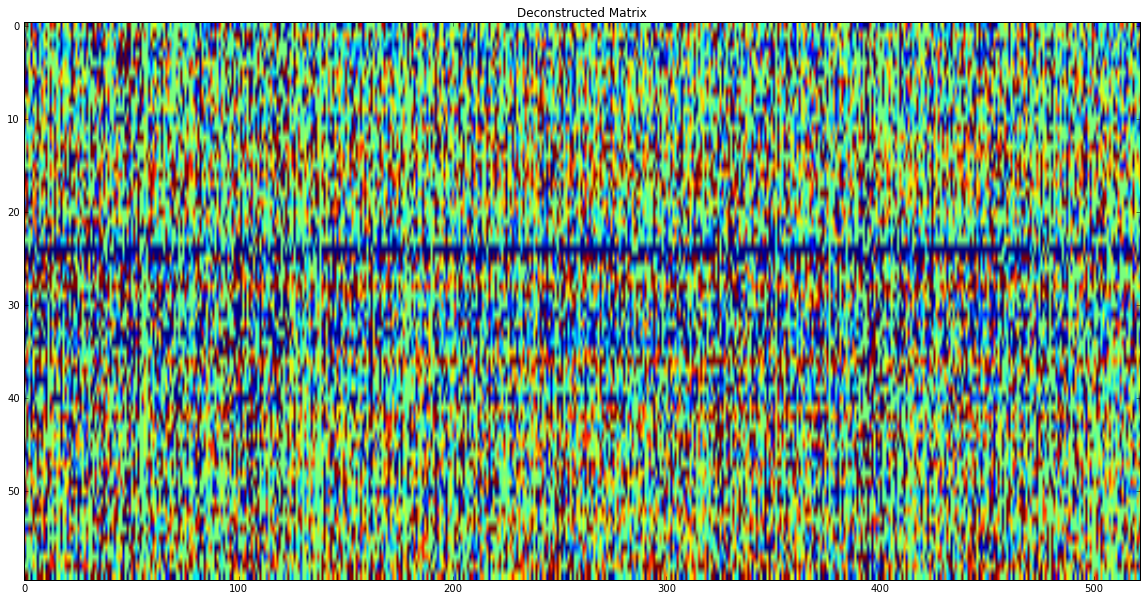

In [46]:
plt.figure(figsize=(20,10))
im = plt.imshow(RHS_MATRIX, vmin=-0.02, vmax=0.02, aspect='auto')
plt.title('Deconstructed Matrix')

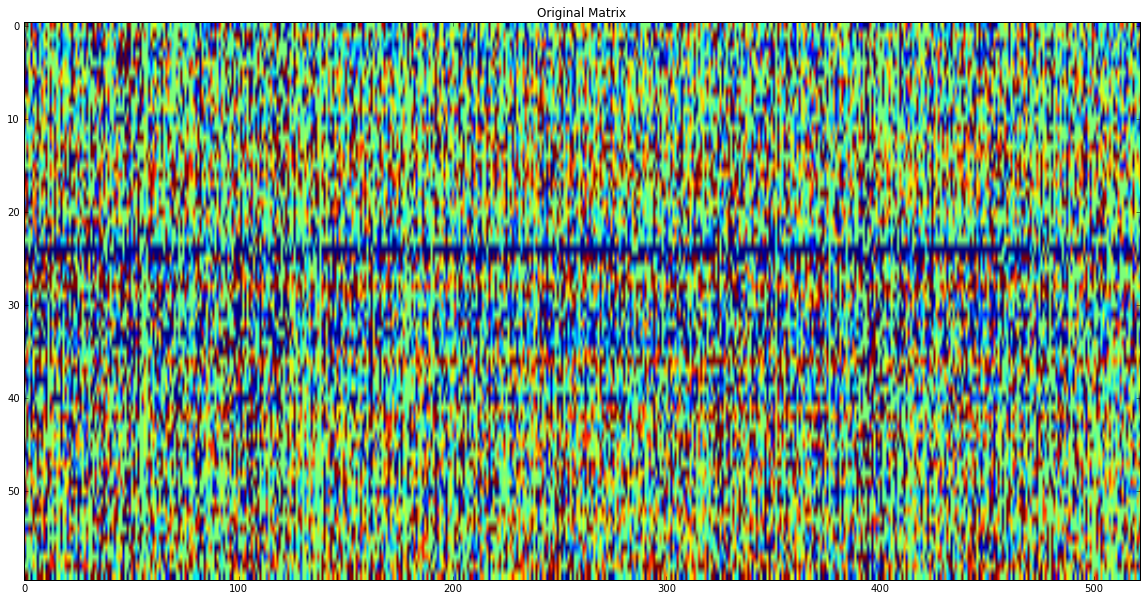

In [47]:
plt.figure(figsize=(20,10))
im = plt.imshow(M, vmin=-0.02, vmax=0.02, aspect='auto')
plt.title('Original Matrix')

In [26]:
def get_distance_matrix(df, root_dir, filename_prefix, name='D'):
    distance = None
    #file_path = get_full_path_2_save(root_dir, filename_prefix + '_' + name + '.dat')
    rows = len(df)
    distance = np.zeros((rows, rows))    
    for i, rowi in df.iterrows():
        print(i)
        for j, rowj in df.iterrows():
            print(j)
            distance[i,j] = norm(rowi - rowj)            
    #distance.dump(get_full_path_2_save(root_dir, filename_prefix + '_D.dat'))
    return distance	


In [31]:
i = 932
width = 60
M = df[i:i+width].copy()
orig_cols_len = len(M.columns)
M.dropna(axis=1, inplace=True)
new_cols_len = len(M.columns)

In [34]:
M.head()
df2 = M.reset_index()
df2.drop('Dates', axis=1, inplace=True)
df2.head()

AAN      AAPL       ABM      ABMD       ABT      ACXM      ADBE  \
0  0.000000  0.021819 -0.004283  0.017628 -0.011561 -0.014052 -0.007380   
1 -0.033523  0.000000 -0.004301  0.025217  0.011561  0.014052 -0.030078   
2  0.011300 -0.021819  0.000000  0.007833 -0.011561  0.018434 -0.015385   
3 -0.069796  0.000000  0.000000 -0.017050  0.005797 -0.004577 -0.055791   
4 -0.024391  0.000000  0.008584 -0.016000  0.005764  0.000000 -0.016529   

        ADI       ADM       ADP    ...          WTR       WTS       WWW  \
0  0.008163 -0.015301 -0.007220    ...     0.012422  0.014231  0.000000   
1 -0.008163 -0.004415  0.003617    ...     0.000000 -0.007638 -0.014185   
2  0.000000 -0.008889  0.003604    ...    -0.012422  0.000000  0.000000   
3  0.000000 -0.006719 -0.007220    ...    -0.012579  0.000000 -0.014389   
4  0.000000 -0.013575  0.010811    ...     0.025001 -0.006593 -0.014599   

         WY       XEL       XOM      XRAY       XRX         Y      YRCW  
0  0.031749 -0.004415  0.006116  0.026668  0.003205 -0.015675 -0.020203  
1 -0.004175  0.000000  0.016129 -0.013245 -0.003205  0.000000  0.008130  
2 -0.027573 -0.006659 -0.020203  0.000000 -0.008058  0.010555 -0.020451  
3 -0.004310 -0.004464  0.004073 -0.027029 -0.014670 -0.005146 -0.025106  
4  0.027691  0.000000  0.006079  0.000000  0.003279 -0.008006 -0.012793  

[5 rows x 522 columns]

In [6]:
dt = df.index[i+width]
filename_prefix = parser.parse(dt).strftime('%Y%m%d')

In [29]:
df2.head()

Dates       AAN      AAPL       ABM      ABMD       ABT      ACXM  \
0  9/11/1989  0.000000  0.021819 -0.004283  0.017628 -0.011561 -0.014052   
1  9/12/1989 -0.033523  0.000000 -0.004301  0.025217  0.011561  0.014052   
2  9/13/1989  0.011300 -0.021819  0.000000  0.007833 -0.011561  0.018434   
3  9/14/1989 -0.069796  0.000000  0.000000 -0.017050  0.005797 -0.004577   
4  9/15/1989 -0.024391  0.000000  0.008584 -0.016000  0.005764  0.000000   

       ADBE       ADI       ADM    ...          WTR       WTS       WWW  \
0 -0.007380  0.008163 -0.015301    ...     0.012422  0.014231  0.000000   
1 -0.030078 -0.008163 -0.004415    ...     0.000000 -0.007638 -0.014185   
2 -0.015385  0.000000 -0.008889    ...    -0.012422  0.000000  0.000000   
3 -0.055791  0.000000 -0.006719    ...    -0.012579  0.000000 -0.014389   
4 -0.016529  0.000000 -0.013575    ...     0.025001 -0.006593 -0.014599   

         WY       XEL       XOM      XRAY       XRX         Y      YRCW  
0  0.031749 -0.004415  0.006116  0.026668  0.003205 -0.015675 -0.020203  
1 -0.004175  0.000000  0.016129 -0.013245 -0.003205  0.000000  0.008130  
2 -0.027573 -0.006659 -0.020203  0.000000 -0.008058  0.010555 -0.020451  
3 -0.004310 -0.004464  0.004073 -0.027029 -0.014670 -0.005146 -0.025106  
4  0.027691  0.000000  0.006079  0.000000  0.003279 -0.008006 -0.012793  

[5 rows x 523 columns]

In [30]:
df.head()

A  AAC  AAL       AAN  AAOI  AAON  AAP      AAPL  AAT  AAWW  ...   \
Dates                                                                   ...    
1/3/1986 NaN  NaN  NaN -0.017544   NaN   NaN  NaN  0.000000  NaN   NaN  ...    
1/6/1986 NaN  NaN  NaN  0.000000   NaN   NaN  NaN  0.000000  NaN   NaN  ...    
1/7/1986 NaN  NaN  NaN  0.000000   NaN   NaN  NaN  0.029853  NaN   NaN  ...    
1/8/1986 NaN  NaN  NaN  0.034786   NaN   NaN  NaN  0.000000  NaN   NaN  ...    
1/9/1986 NaN  NaN  NaN -0.034786   NaN   NaN  NaN  0.000000  NaN   NaN  ...    

          ZG  ZGNX  ZION  ZIOP  ZIXI  ZLTQ  ZNGA  ZOES  ZTS  ZUMZ  
Dates                                                              
1/3/1986 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  
1/6/1986 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  
1/7/1986 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  
1/8/1986 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  
1/9/1986 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  

[5 rows x 2966 columns]

In [27]:
df2 = M.reset_index()
D = get_distance_matrix(df2, r"C:\phd\input\rpca\euclidean", filename_prefix, name='D')

0
0


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [21]:
# df2 = M.reset_index()
# [i for i, rowi in df2.iterrows()]